<a href="https://colab.research.google.com/github/pradeep2005s2/Audio-Speech-Analysis/blob/master/DHAI_Project_Speech_Emotion_Recognition_Using_Deep_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DHAI Project: Speech Emotion Recognition Using Deep Neural Networks.ipynb

Authors: Anu, Pradeep | 
Contacts: anu.chacko@nitc.ac.in , pradeep2005s1@gmail.com 

###Load Libraries

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

### Download Kaggle dataset

In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pradeep2005s1","key":"b3ca9be29ab510a18499edb878840cbf"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
! unzip ravdess-emotional-speech-audio.zip -d /content/sample_data/ravdess-emotional-speech-audio/

In [ ]:
! kaggle datasets download -d jamaliasultanajisha/audiowav-cremad
! unzip audiowav-cremad.zip -d /content/sample_data/AudioWAV/

In [ ]:
! kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
! unzip toronto-emotional-speech-set-tess.zip -d /content/sample_data/toronto-emotional-speech-set-tess/

In [ ]:
! kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee
! unzip surrey-audiovisual-expressed-emotion-savee.zip -d /content/sample_data/surrey-audiovisual-expressed-emotion-savee/

### Import data + store in data frame + Stats

In [ ]:
Ravdess = '/content/sample_data/ravdess-emotional-speech-audio/audio_speech_actors_01-24/'
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0      calm  /content/sample_data/ravdess-emotional-speech-...
1   disgust  /content/sample_data/ravdess-emotional-speech-...
2  surprise  /content/sample_data/ravdess-emotional-speech-...
3      calm  /content/sample_data/ravdess-emotional-speech-...
4       sad  /content/sample_data/ravdess-emotional-speech-...

In [ ]:
Crema = "/content/sample_data/AudioWAV/AudioWAV_cremad/"

crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0  Unknown  /content/sample_data/AudioWAV/AudioWAV_cremad/...
1  Unknown  /content/sample_data/AudioWAV/AudioWAV_cremad/...
2  Unknown  /content/sample_data/AudioWAV/AudioWAV_cremad/...
3  Unknown  /content/sample_data/AudioWAV/AudioWAV_cremad/...
4  Unknown  /content/sample_data/AudioWAV/AudioWAV_cremad/...

In [ ]:
Tess = "/content/sample_data/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"


tess_directory_list = os.listdir(Tess)
file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0  neutral  /content/sample_data/toronto-emotional-speech-...
1  neutral  /content/sample_data/toronto-emotional-speech-...
2  neutral  /content/sample_data/toronto-emotional-speech-...
3  neutral  /content/sample_data/toronto-emotional-speech-...
4  neutral  /content/sample_data/toronto-emotional-speech-...

In [ ]:
savee_directory_list

['JE', 'Info.txt', 'KL', 'JK', 'DC']

In [ ]:
Savee = "/content/sample_data/surrey-audiovisual-expressed-emotion-savee/ALL/"
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    print(file_path) 
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise') 
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Emotions                                               Path
0  disgust  /content/sample_data/surrey-audiovisual-expres...
1     fear  /content/sample_data/surrey-audiovisual-expres...
2  disgust  /content/sample_data/surrey-audiovisual-expres...
3    angry  /content/sample_data/surrey-audiovisual-expres...
4  neutral  /content/sample_data/surrey-audiovisual-expres...

In [ ]:
#data_path = pd.concat([Ravdess_df, Crema_df], axis = 0)
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0      calm  /content/sample_data/ravdess-emotional-speech-...
1   disgust  /content/sample_data/ravdess-emotional-speech-...
2  surprise  /content/sample_data/ravdess-emotional-speech-...
3      calm  /content/sample_data/ravdess-emotional-speech-...
4       sad  /content/sample_data/ravdess-emotional-speech-...

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


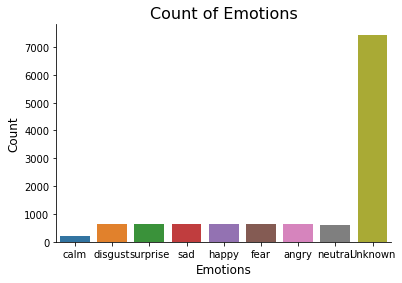

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

### Explore Data: Listen, Visualize waveplot and mel-spectrogram

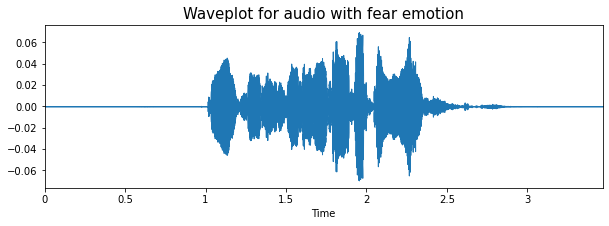

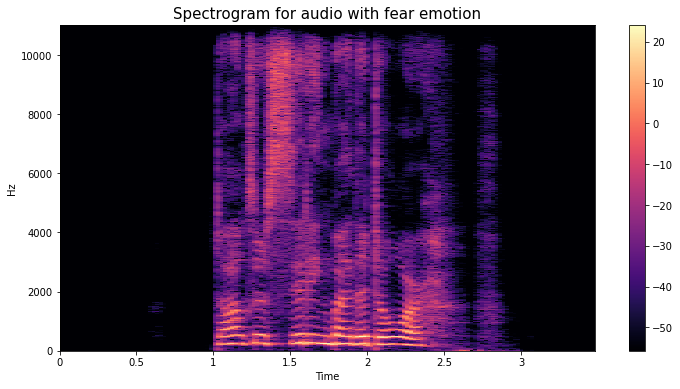

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 6))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

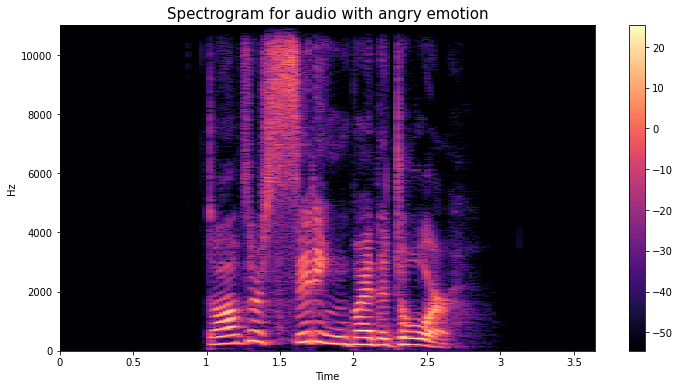

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

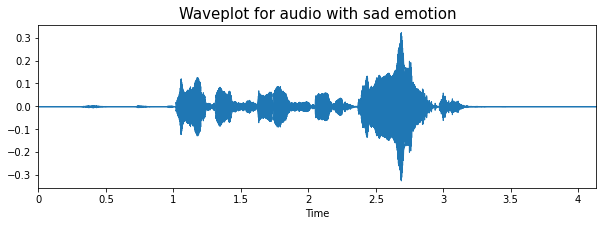

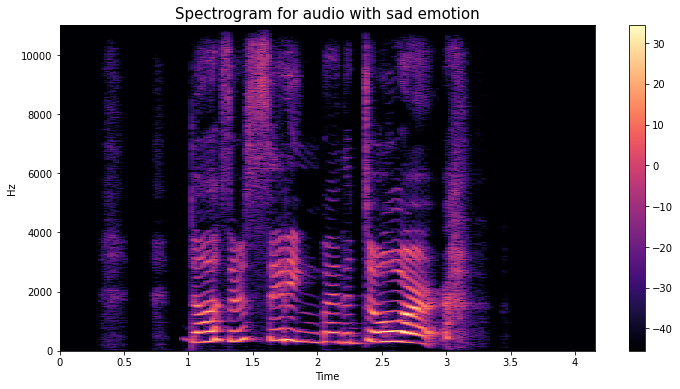

In [ ]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

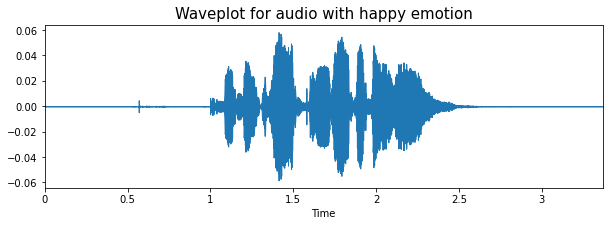

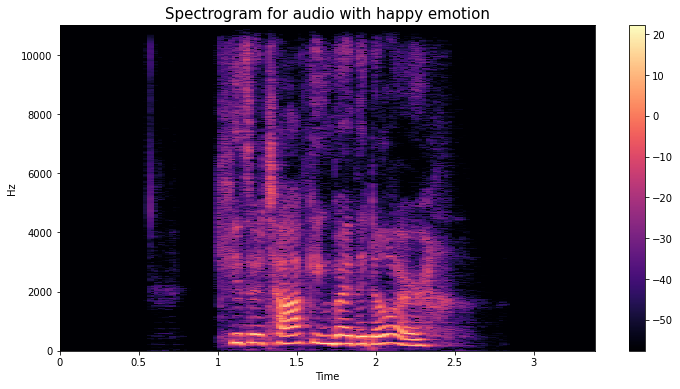

In [ ]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

### Augment data

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

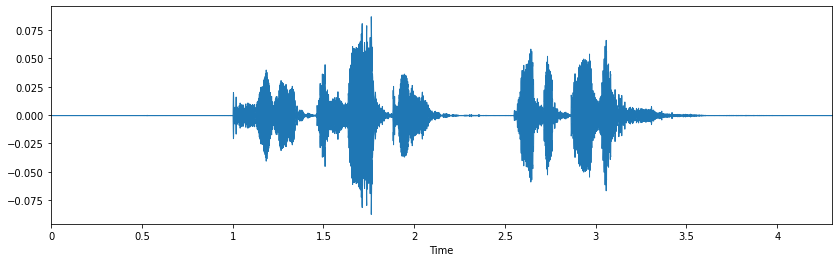

In [ ]:
#simple audio
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)


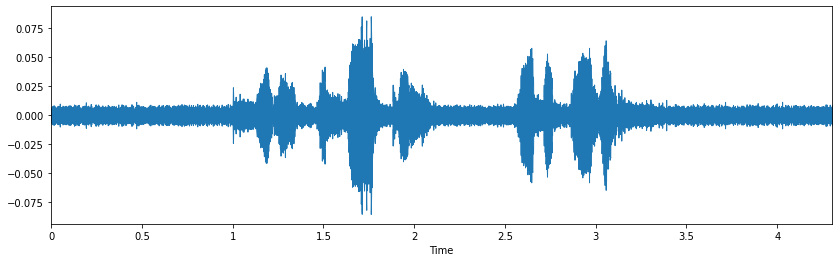

In [ ]:
#noise injection
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

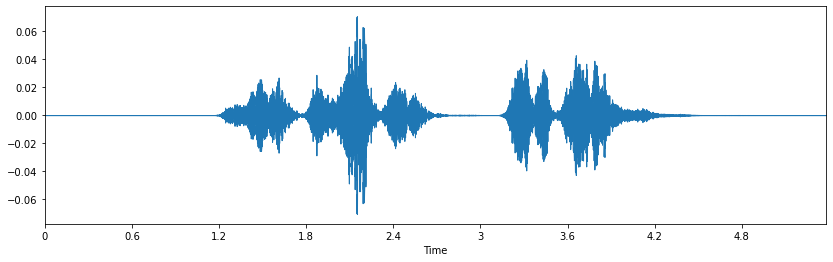

In [ ]:
#stretching
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

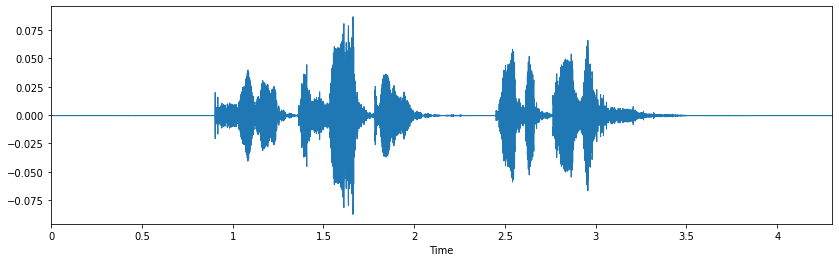

In [ ]:
#shifting
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

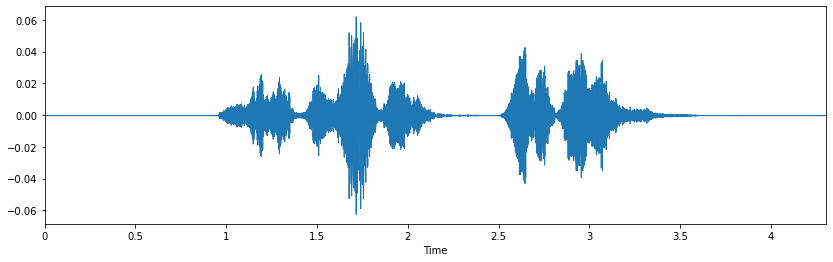

In [ ]:
#pitch
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Extract Features using Librosa feature extraction APIs
https://librosa.org/doc/main/feature.html

In [ ]:
def extract_features(data):
    #https://librosa.org/doc/main/feature.html#spectral-features
    #https://wiki.aalto.fi/display/ITSP/Cepstrum+and+MFCC

    # ZCR - Zero Crossing Rate
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft - Compute a chromagram from a waveform or power spectrogram.
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC Mel-frequency cepstral coefficients (MFCCs) - important part of the audio get importance (perception)
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value: Compute root-mean-square (RMS) value for each frame, either from the audio samples y or from a spectrogram
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram: Compute a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

### Create data frame to use in training, validation and testing the model

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)


/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [61]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

#### Write features data into file for future loading
NOTE: Slow - do it only once

In [62]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2  ...           160           161   labels
0  0.225600  0.528877  0.520975  ...  4.960727e-06  3.560823e-07     calm
1  0.231477  0.591697  0.565210  ...  7.512564e-06  3.015755e-06     calm
2  0.143312  0.536367  0.493291  ...  9.915742e-07  4.900811e-08     calm
3  0.186835  0.659039  0.632515  ...  4.007552e-05  3.108452e-06  disgust
4  0.289099  0.722229  0.752900  ...  1.407465e-04  1.052342e-04  disgust

[5 rows x 163 columns]

#### Load features from a file ( new session )

In [132]:
Features= pd.read_csv('/content/features.csv')
Features.head()

0         1         2  ...           160           161   labels
0  0.225600  0.528877  0.520975  ...  4.960727e-06  3.560823e-07     calm
1  0.231477  0.591697  0.565210  ...  7.512564e-06  3.015755e-06     calm
2  0.143312  0.536367  0.493291  ...  9.915742e-07  4.900811e-08     calm
3  0.186835  0.659039  0.632515  ...  4.007552e-05  3.108452e-06  disgust
4  0.289099  0.722229  0.752900  ...  1.407465e-04  1.052342e-04  disgust

[5 rows x 163 columns]

#### One hot enoding of labeled data and display data size

In [134]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
enc.fit(Y.reshape(Y.shape[0],1))
enc.categories_
Y = enc.transform(Y.reshape(Y.shape[0],1)).toarray()
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 9), (9122, 162), (9122, 9))

In [135]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 9), (9122, 162, 1), (9122, 9))

### Build 1D Conv Model

Model Arcitecture:
1. input
2. conv1d > filter > relu > maxpooling
3. Conv1d > filter > relu > maxpooling > dropout
4. conv1d > filter > relu > maxpooling > flatten
5. Dense > relu > dropout
6. Dense > softmax 
7. output

In [136]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(162, 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=9, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 81, 256)           0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 81, 256)           327936    
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 41, 256)           0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 21, 128)           0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 21, 128)          

### Train, Validation and Test the model

In [137]:
epoch = 50
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.001)
history=model.fit(x_train, y_train, batch_size=64, epochs=epoch, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
428/428 [==============================] - 186s 431ms/step - loss: 1.0522 - accuracy: 0.6770 - val_loss: 0.5118 - val_accuracy: 0.8220
Epoch 2/50
428/428 [==============================] - 182s 426ms/step - loss: 0.5372 - accuracy: 0.8044 - val_loss: 0.4083 - val_accuracy: 0.8471
Epoch 3/50
428/428 [==============================] - 181s 424ms/step - loss: 0.4539 - accuracy: 0.8328 - val_loss: 0.3955 - val_accuracy: 0.8584
Epoch 4/50
428/428 [==============================] - 181s 422ms/step - loss: 0.4096 - accuracy: 0.8492 - val_loss: 0.3447 - val_accuracy: 0.8646
Epoch 5/50
428/428 [==============================] - 180s 421ms/step - loss: 0.3767 - accuracy: 0.8589 - val_loss: 0.3172 - val_accuracy: 0.8804
Epoch 6/50
428/428 [==============================] - 178s 416ms/step - loss: 0.3543 - accuracy: 0.8735 - val_loss: 0.3152 - val_accuracy: 0.8828
Epoch 7/50
428/428 [==============================] - 179s 418ms/step - loss: 0.3205 - accuracy: 0.8821 - val_loss: 0.3150 -

### Model performance

286/286 [==============================] - 13s 46ms/step - loss: 0.2310 - accuracy: 0.9292
Accuracy of our model on test data :  92.91821718215942 %


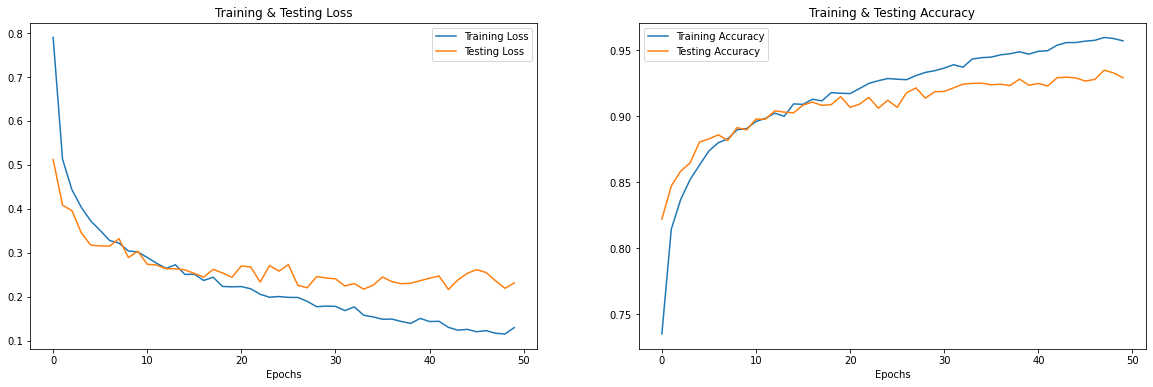

In [138]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(epoch)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [139]:
pred_test = model.predict(x_test)
y_pred = enc.inverse_transform(pred_test)
#y_test = encoder.inverse_transform(y_test)
y_test = enc.inverse_transform(y_test)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0          Unknown       Unknown
1              sad           sad
2          neutral       neutral
3          Unknown       Unknown
4          Unknown       Unknown
5          Unknown       Unknown
6          disgust         angry
7          disgust       disgust
8          Unknown       Unknown
9            happy         happy

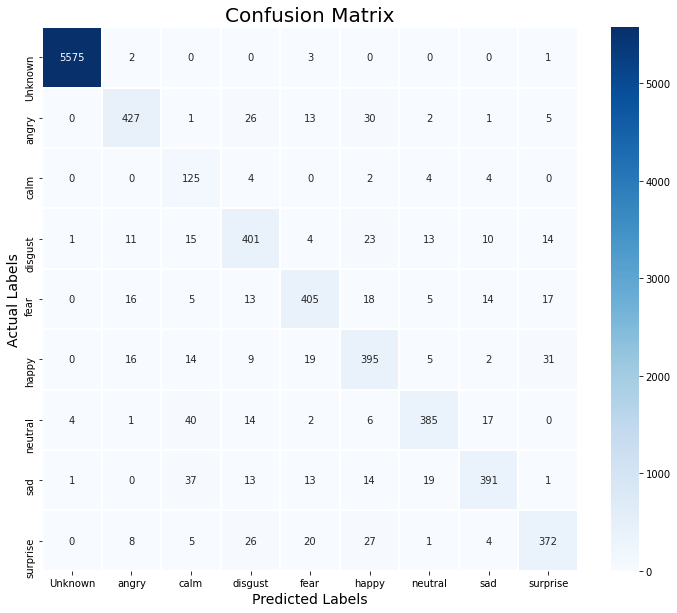

In [140]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in enc.categories_] , columns = [i for i in enc.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [141]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Unknown       1.00      1.00      1.00      5581
       angry       0.89      0.85      0.87       505
        calm       0.52      0.90      0.66       139
     disgust       0.79      0.82      0.80       492
        fear       0.85      0.82      0.83       493
       happy       0.77      0.80      0.79       491
     neutral       0.89      0.82      0.85       469
         sad       0.88      0.80      0.84       489
    surprise       0.84      0.80      0.82       463

    accuracy                           0.93      9122
   macro avg       0.82      0.85      0.83      9122
weighted avg       0.93      0.93      0.93      9122



##ToDo


Audiofiles > MEL_Spectro >> pickle >> shave as image file >> organize folders >> split trian and test >> 2DConv 

ROC curve

AUC curve

##SCRAP


In [ ]:
#To bypass any remote network access and use the local copies of the data files directly.
import os
os.environ['LIBROSA_DATA_DIR'] = '/path/to/librosa-data/audio'
import librosa
